In [22]:
import os
import sys
import cv2
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [23]:
print(torch.__version__)

1.7.1


In [24]:
img = cv2.imread('pers.png', -1)
img = img.astype(np.float32) / 255

[h, w, _] = img.shape
FOV = 80
wFOV = FOV
THETA = -20
PHI = -20
hFOV = float(h) / w * wFOV
width = 1024
height = 512
w_len = math.tan(math.radians(wFOV / 2.0))
h_len = math.tan(math.radians(hFOV / 2.0))

In [25]:
y, x= torch.meshgrid(torch.linspace(90,-90,height), torch.linspace(-180, 180,width))
x_map = torch.cos(torch.deg2rad(x)) * torch.cos(torch.deg2rad(y))
y_map = torch.sin(torch.deg2rad(x)) * torch.cos(torch.deg2rad(y))
z_map = torch.sin(torch.deg2rad(y))
xyz = torch.stack((x_map,y_map,z_map),axis=2)


In [26]:
y_axis = torch.as_tensor([0.0, 1.0, 0.0], dtype=torch.float32)
z_axis = torch.as_tensor([0.0, 0.0, 1.0], dtype=torch.float32)

In [27]:
def rotation_matrix(theta, axis):
    axis = axis / math.sqrt(torch.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    ROT = torch.tensor([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]], device='cpu', dtype=torch.float32)
    return ROT

In [28]:
R1 = rotation_matrix(math.radians(THETA), z_axis)
R2 = rotation_matrix(math.radians(-PHI), torch.matmul(R1, y_axis))
R1 = torch.inverse(R1)
R2 = torch.inverse(R2)

In [29]:
xyz = xyz.reshape([height * width, 3]).transpose(1, 0)
xyz = torch.matmul(R2, xyz)
xyz = torch.matmul(R1, xyz).transpose(1, 0)

In [30]:
xyz = xyz.view(height, width, 3)
inverse_mask = torch.where(xyz[:,:,0]>0,1,0)
xyz[:,:] = xyz[:,:]/(xyz[:,:,0].unsqueeze(2).repeat(1,1,3))
#xyz[:,:] = xyz[:,:]/np.repeat(xyz[:,:,0][:, :, np.newaxis], 3, axis=2)

In [31]:
lon_map = torch.where((-w_len<xyz[:,:,1])&(xyz[:,:,1]<w_len)&(-h_len<xyz[:,:,2])
                    &(xyz[:,:,2]<h_len),(xyz[:,:,1]+w_len)/2/w_len*float(w),torch.tensor(0, dtype=torch.float32))
lat_map = torch.where((-w_len<xyz[:,:,1])&(xyz[:,:,1]<w_len)&(-h_len<xyz[:,:,2])
                    &(xyz[:,:,2]<h_len),(-xyz[:,:,2]+h_len)/2/h_len*float(h),torch.tensor(0, dtype=torch.float32))
mask = torch.where((-w_len<xyz[:,:,1])&(xyz[:,:,1]<w_len)&(-h_len<xyz[:,:,2])
                    &(xyz[:,:,2]<h_len),1,0)

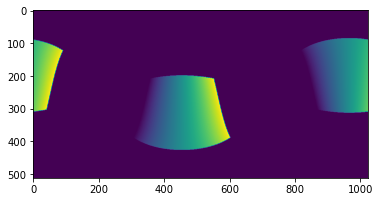

In [32]:
plt.imshow(lon_map)
plt.show()

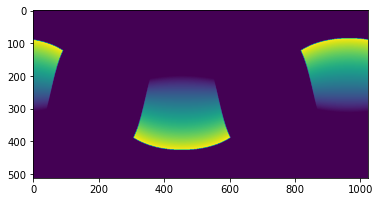

In [33]:
plt.imshow(lat_map)
plt.show()

In [34]:
lon_map = (lon_map / w - 0.5)*2
lat_map = (lat_map / h - 0.5)*2

In [35]:
print(lon_map.min(), lon_map.max())

tensor(-1.) tensor(1.0000)


In [36]:
grid = torch.stack([lon_map, lat_map], -1)
grid = grid.unsqueeze(0)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).unsqueeze(0)

In [37]:
sample_erp = F.grid_sample(img, grid, mode='bilinear', padding_mode='zeros',align_corners=True)

In [38]:
mask = mask * inverse_mask
sample_erp = sample_erp * mask.view(1, 1, height, width)

In [39]:
sample_erp = sample_erp[0].permute(1, 2, 0).numpy()

In [40]:
sample_erp = (sample_erp * 255).astype(np.uint8)

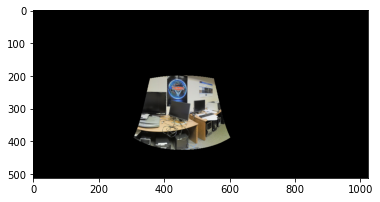

In [41]:
plt.imshow(sample_erp[:,:,[2,1,0]])
plt.show()

In [42]:
cv2.imshow('equi', sample_erp)
cv2.waitKey(0) 
cv2.destroyWindow('equi')